## CMM262: ChIP-seq workshop – Part 2

Following the steps 1-5 on from Part 1, you should have a tagdirectory for each of the datasets (6 in total) and you should also have the UCSCfiles.   

As we discussed, each dataset was created by a different antibody, and they can be divided into three types: TFs (transcription factors) HMs (histone modifications) and global input (background). Since we will need to treat each type differently, I recommend making a directory for each – input, TFs and HMs and move the tag directories to the relevant one (e.g. tfs/oct4-esc/, etc.).

**Run all homer commands in your terminal. First make sure to activate the r-bio conda environment. Make sure you are in the module-9-chipseq folder.**

In [ ]:
%%bash
source activate r-bio

In [ ]:
%%bash
mkdir -p chipseq_workshop/tagdirs/hms/
mkdir -p chipseq_workshop/tagdirs/tfs/
mkdir -p chipseq_workshop/tagdirs/input/

In [ ]:
%%bash
mv chipseq_workshop/tagdirs/h3* chipseq_workshop/tagdirs/hms/
mv chipseq_workshop/tagdirs/input-esc/ chipseq_workshop/tagdirs/input/
mv chipseq_workshop/tagdirs/*esc chipseq_workshop/tagdirs/tfs/

---
**6. One of the most common tasks with ChIP-seq data is to find ‘enriched’ regions commonly called “peaks”.** HOMER contains a command called findPeaks which is used to analyze tag directories for peaks. There are two common ways to use the command:

```
findPeaks <tag directory> -i <control tag directory> -style factor  -o auto
```

or

```
findPeaks <path>/oct4-esc/ -i <path>/input-esc/ -style histone -o auto
```

The difference between the two is in the “-style factor/histone” argument, which will tell the program to look for focal, fixed width peaks (factor; i.e. TF) vs. variable length peaks (histone; i.e. HM); the later is more common in the case of histone modifications. To find Oct4 peaks in the data, run the following command:

```
findPeaks <path>/oct4-esc/ -i <path>/input-esc/ -style factor -o auto
```
  
This command will look for enriched regions and filter them based on several criterion, including ensuring that they have at least 4-fold more reads in peak regions relative to the control experiment (in this case `input-esc/`). The output will be stored in a HOMER-style peak file located in the Oct4 tag directory (`oct4-esc/peaks.txt`). The beginning of this file contains statistics and QC stats from the peak finding, including the number of peaks, number of peaks lost to input filtering, etc.     

One field worth paying attention to is the **“Approximate IP efficiency”** which reports what fraction of reads from the experiment were actually found in peaks. For most decent experiments this value ranges from 1% to >30% (remember ChIP is an enrichment strategy... there is plenty of background in the data too!). Below this are the peaks along with enrichment statistics for each region.

One other thing to note is that HOMER reports the results in a ‘peak’ file, which has a slightly different format from a traditional BED file format. To create a BED file from the peak file, use the tool pos2bed.pl (e.g. `pos2bed.pl oct4-esc/peaks.txt > oct4-esc.bed`. The “`> output.txt`” part at the end means that the results will be sent to stdout, and the “`> output.txt`” is used to capture the output information in a file.). BED files can be uploaded to IGV just like a bedGraph file. Also, most HOMER programs will work with either BED or peak files as input.


Next we will find peaks for all samples using two ‘for loops’ – for the two types of data:


In [ ]:
%%bash
for dir in chipseq_workshop/tagdirs/hms/*; do
    nohup findPeaks "$dir" -i chipseq_workshop/tagdirs/input/input-esc/ -style histone -o auto > "$dir"/findPeaks.out &
done

and

In [ ]:
%%bash
for dir in chipseq_workshop/tagdirs/tfs/*; do
    nohup findPeaks "$dir" -i chipseq_workshop/tagdirs/input/input-esc/ -style factor -o auto > "$dir"/findPeaks.out &
done

Make a directory for the annotation files (e.g., “annotations”) and convert the peak.txt and region.txt files to bed files:


In [ ]:
%%bash
mkdir -p chipseq_workshop/annotations

In [ ]:
%%bash
for dir in chipseq_workshop/tagdirs/hms/*; do
    dirname="$(basename $dir)"
    pos2bed.pl "$dir"/regions.txt > chipseq_workshop/annotations/"$dirname".bed
done

and

In [ ]:
%%bash
for dir in chipseq_workshop/tagdirs/tfs/*; do
    dirname="$(basename $dir)";
    pos2bed.pl "$dir"/peaks.txt > chipseq_workshop/annotations/"$dirname".bed;
done


Copy the bed files to your local computer and load to IGV. Explore the original (previous to conversion to bed) peaks.txt and regions.txt files with less -S in the command line. For instance, each peak gets a score, see how the ones with high scores look on IGV vs. ones with low scores. 

---
**7. Now that we have identified peaks from our ChIP-seq data, it is time to figure out more information about where they are and what genes they might be regulating.** 

HOMER contains a program called annotatePeaks.pl that performs a wide variety of functions using peak/BED files. First, lets use it to perform basic annotation of the peak file. The annotatePeaks.pl program works like this:


```
annotatePeaks.pl <peak/BED file> <genome version> [options] > output.txt
```

To annotate peaks from the Oct4 experiment:

```
annotatePeaks.pl <path>/oct4-esc/peaks.txt mm9 > <path>/annotations/oct4.annotation.txt
```

You can do it using a for loop for the two types of datasets:

In [ ]:
%%bash
for dir in chipseq_workshop/tagdirs/hms/*; do
    dirname="$(basename $dir)"
    nohup annotatePeaks.pl "$dir"/regions.txt chipseq_workshop/mm9 > chipseq_workshop/annotations/"$dirname".annotation.txt &
done

and for tfs:

In [ ]:
%%bash
for dir in chipseq_workshop/tagdirs/tfs/*; do
    dirname="$(basename $dir)"; 
    nohup annotatePeaks.pl "$dir"/peaks.txt chipseq_workshop/mm9 > chipseq_workshop/annotations/"$dirname".annotation.txt &
done

If we view the `“oct4.annotation.txt”` file with `less -S`, you’ll see several annotation columns. Take note of the columns specifying the nearest gene TSS, the distance, and the annotation of the genomic region the peak is located in. This annotation is split into two separate columns – one is basic (i.e., exon, promoter, intergenic, intron etc.), and a more detailed annotation that describes CpG islands, repeat elements, etc. You might have also noticed while the command was running that stats about annotation enrichment too.

---
**8. The annotatePeaks.pl program can also be used to create histograms that display the read enrichment relative to given genomic features**, including transcription start sites (TSS) or any other set of regions the user wants to define. Since the TSS is so commonly used for this purpose, HOMER has a built-in annotation for TSS (based on RefSeq transcripts). The key parameters to create a histogram are the `-hist #` and `-size #` options, which control the binning size and total length of the histogram. The other important option is the `-d <tag directory>`, which specifies which experiments to compile histograms for. In general:

```
annotatePeaks.pl <peak/BED file> <genome version> -size <#> -hist <#> -d <Tag Directory> > output.txt
```
  
(note that the peak/BED file can be replaced with the key word “tss” to make a histogram at the TSS). To create a histogram near the TSS with the data from the experiments we’ve looked at thus far, run the following:



In [ ]:
%%bash
# should take ~30 secs
annotatePeaks.pl tss chipseq_workshop/mm9 -size 8000 -hist 10 -d chipseq_workshop/tagdirs/hms/*-esc chipseq_workshop/tagdirs/tfs/*-esc chipseq_workshop/tagdirs/input/input-esc/ > chipseq_workshop/annotations/tss-histogram.txt

Let's check out the “tss-histogram.txt” file using pandas! You’ll notice that the first column gives the distance offsets from the TSS followed by columns corresponding to the ‘coverage’, ‘+ Tags’, and ‘- Tags’ for each experiment. Try graphing each as X-Y line graph using the first column as the X-coordinate to see the patterns.

In [1]:
import pandas as pd

histogram_df = pd.read_csv('chipseq_workshop/annotations/tss-histogram.txt', sep='\t', index_col=0)
histogram_df.head()

,chipseq_workshop/tagdirs/hms/h3k27ac-esc Coverage,chipseq_workshop/tagdirs/hms/h3k27ac-esc + Tags,chipseq_workshop/tagdirs/hms/h3k27ac-esc - Tags,chipseq_workshop/tagdirs/hms/h3k4me2-esc Coverage,chipseq_workshop/tagdirs/hms/h3k4me2-esc + Tags,chipseq_workshop/tagdirs/hms/h3k4me2-esc - Tags,chipseq_workshop/tagdirs/tfs/klf4-esc Coverage,chipseq_workshop/tagdirs/tfs/klf4-esc + Tags,chipseq_workshop/tagdirs/tfs/klf4-esc - Tags,chipseq_workshop/tagdirs/tfs/oct4-esc Coverage,chipseq_workshop/tagdirs/tfs/oct4-esc + Tags,chipseq_workshop/tagdirs/tfs/oct4-esc - Tags,chipseq_workshop/tagdirs/tfs/sox2-esc Coverage,chipseq_workshop/tagdirs/tfs/sox2-esc + Tags,chipseq_workshop/tagdirs/tfs/sox2-esc - Tags,chipseq_workshop/tagdirs/input/input-esc/ Coverage,chipseq_workshop/tagdirs/input/input-esc/ + Tags,chipseq_workshop/tagdirs/input/input-esc/ - Tags
Distance from Center (cmd=annotatePeaks.pl tss chipseq_workshop/mm9 -size 8000 -hist 10 -d chipseq_workshop/tagdirs/hms/h3k27ac-esc chipseq_workshop/tagdirs/hms/h3k4me2-esc chipseq_workshop/tagdirs/tfs/klf4-esc chipseq_workshop/tagdirs/tfs/oct4-esc chipseq_workshop/tagdirs/tfs/sox2-esc chipseq_workshop/tagdirs/input/input-esc/),,,,,,,,,,,,,,,,,,
-4000,1.121706,0.004657,0.004168,1.254292,0.005252,0.005290,0.896240,0.003955,0.004291,0.847539,0.003634,0.003661,0.795724,0.003382,0.003382,0.702895,0.002637,0.003403
-3990,1.106234,0.004214,0.005603,1.230895,0.004552,0.005430,0.884941,0.003175,0.004775,0.847896,0.003300,0.003580,0.787460,0.003045,0.003153,0.700743,0.003417,0.003255
-3980,1.081398,0.005222,0.004962,1.228522,0.004972,0.005468,0.885838,0.004358,0.003995,0.836852,0.003367,0.003754,0.784226,0.003625,0.003517,0.689443,0.003282,0.002825
-3970,1.050658,0.003817,0.004122,1.220892,0.005086,0.004997,0.900366,0.003874,0.003955,0.847896,0.003821,0.003888,0.784945,0.003894,0.003746,0.696618,0.003067,0.003551
-3960,1.068369,0.005100,0.004672,1.216145,0.004857,0.005481,0.901800,0.003955,0.004036,0.835248,0.003888,0.003580,0.769134,0.003382,0.003665,0.697514,0.003793,0.002811


Text(0.5, 1.0, 'Distance from TSS for each transcription factor or histone modification')

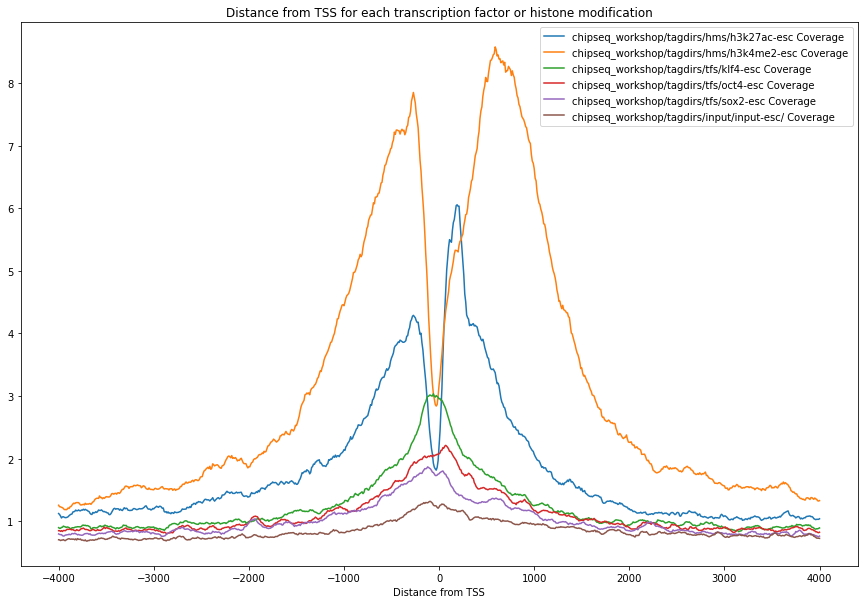

In [2]:
from matplotlib import pyplot as plt

legend = []
plt.figure(figsize=(15, 10))
for column_name in histogram_df.columns:
    if 'Coverage' in column_name:
        histogram_df[column_name].plot()
        plt.xlabel('Distance from TSS')
        legend.append(column_name)
    plt.legend(legend)
plt.title('Distance from TSS for each transcription factor or histone modification')

---
### Motif finding

**9. DNA motif finding is a powerful technique to analyze ChIP-seq experiments.** Unlike gene expression data, ChIP-seq localizes signals to very specific regions of the genome allowing for accurate identification of the genetic signals responsible for recruiting various transcription factors. To use HOMER’s motif analysis program, run the findMotifsGenome.pl command using peak files from the experiments. In general the command works like this:

```
findMotifsGenome.pl <peak/BED file> <genome version> <output directory> [options]
```

Common options for motif finding are `-p <#cpu>` for parallel execution, and `-size <#>` to specify the size of the regions you which to search for DNA motifs. For transcription factor motifs, a good size is 100. Make a new directory (e.g., “motifs”). 


In [3]:
%%bash
mkdir -p chipseq_workshop/motifs

To find enriched motifs, copy the following for loop into your terminal to run it (again, make sure you are in the module-9-chipseq directory):

In [ ]:
%%bash
# note that this will take ~7-8 mins to run
for dir in chipseq_workshop/tagdirs/tfs/*; do
    dirname="$(basename $dir)"
    mkdir -p chipseq_workshop/motifs/"$dirname"
    nohup findMotifsGenome.pl "$dir"/peaks.txt chipseq_workshop/mm9 chipseq_workshop/motifs/"$dirname" -mask -size 100 -p 10 > chipseq_workshop/motifs/"$dirname"/findMotifsGenome.out &
done

This command will perform several different steps, including checking for the enrichment of a library of known transcription factor motifs as well as perform a de novo search for enriched motifs. The “-mask” tells the program to mask repeat sequences in the genome. Depending on the speed of your server this program may take while to run. Once it’s finished, check out the homerResults.html files.

This file will list the top de novo motifs found as well as provide stats and best matches to known transcription factor motifs. A second file called knownResults.html contains the enrichment statistics for known motifs. 

You might notice that both analyses indicate that Oct4 and Sox2 peaks in ESC are highly enriched for an OCT:SOX composite motif, which has been shown to be very important in establishing pluripotent enhancers.

---
**10. Now that you’ve found the most enriched motifs in a ChIP-seq experiment, it is worth it to see where those motifs are located (i.e., which peaks, etc.)**. One of the key outputs from motif finding are “motif files”, which contain the information needed to understand where the motif is located in the genome. For example, the top de novo motifs found during motif finding are located in the output directory in the homerResults/ directory. To make it easier, lets copy the top Oct4 motif to the file “topOct4.motif” in the main directory where we are executing these commands (alternatively you could save the motif file down from the HTML results):


In [ ]:
%%bash
mkdir -p chipseq_workshop/motifs/analysis
cp chipseq_workshop/motifs/oct4-esc/homerResults/motif1.motif chipseq_workshop/motifs/analysis/topOct4.motif


Now lets perform two separate analyses: first, lets create a histogram showing the motif positions relative to Oct4 peaks so we can check if it really looks enriched relative to the center of the Oct4 peaks. We can do this using the annotatePeaks.pl program like before, but instead of looking at read densities with the `-d <tag directory>` option, we can look at motif densities using the `-m <motif file>` option instead:


In [ ]:
%%bash
annotatePeaks.pl chipseq_workshop/tagdirs/tfs/oct4-esc/peaks.txt chipseq_workshop/mm9/ -size 2000 -hist 10 -m chipseq_workshop/motifs/analysis/topOct4.motif > chipseq_workshop/motifs/analysis/output.Oct4motifHistogram.txt

Let's check out output.Oct4motifHistogram.txt, and create an X-Y plot to examine the distribution of the motif relative to the peaks.



Text(0.5, 0, 'Distance from center')

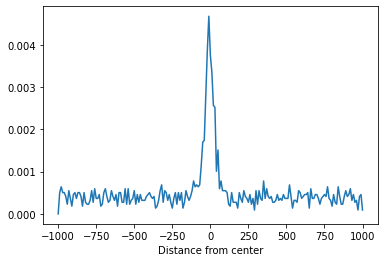

In [4]:
import pandas as pd
oct4motif_df = pd.read_csv('chipseq_workshop/motifs/analysis/output.Oct4motifHistogram.txt', sep='\t', index_col=0)
oct4motif_df[oct4motif_df.columns[0]].plot()
plt.xlabel("Distance from center")

Next, lets see where these motifs are located in the actual genome browser. To do this, we can run annotatePeaks.pl again, but this time we will not make a histogram and instead use the `-mbed <bedfile>` option to tell it to create a bed file of the motif positions that we can upload to the genome browser. Try the following:


In [ ]:
%%bash
# will take ~30 secs
annotatePeaks.pl chipseq_workshop/tagdirs/tfs/oct4-esc/peaks.txt chipseq_workshop/mm9/ -mbed chipseq_workshop/topOct4.motifTrack.bed -m chipseq_workshop/motifs/analysis/topOct4.motif > chipseq_workshop/peaks-topOct4motif.txt

Now you can download and then load the `topOct4.motifTrack.bed` to IGV. In addition, the other output file `peaks-topOct4motif.txt` will contain the peak annotation results with an additional column showing the peaks that contain the given motif.

---

**11. Finally, we want to gain some experience comparing ChIP-seq experiments.** At first pass it might make sense to make a Venn diagram comparing peaks from two experiments to see how many overlap. This is a horrible way to analyze ChIP-seq data!!! 
This is because many peaks are close to the threshold of detection, barely making the cut for statistical significance (or not) in one experiment or another. A good practice is to create a scatter plot comparing the read counts between two experiments directly at all of the sites where there is signal (i.e., peaks). To do this, first lets merge the peak files from the two experiments, collapsing peaks found that overlap:


In [ ]:
%%bash
mergePeaks chipseq_workshop/tagdirs/tfs/oct4-esc/peaks.txt chipseq_workshop/tagdirs/tfs/sox2-esc/peaks.txt > chipseq_workshop/oct4andsox2.peaks.txt

When you run this command, you’ll notice that it will print out the numbers of overlapping and unique peaks from each file (i.e., Venn diagram). This can be useful to give you a general idea of how similar the experiments are, but be careful not to over interpret these values. Now that you have the combined features in the “oct4andsox2.peaks.txt” file, lets use annotatePeaks.pl to quantify the read counts from each experiment at each of the peaks by specify each tag directory with the -d option like the following:


In [ ]:
%%bash
# will take ~30 secs
annotatePeaks.pl chipseq_workshop/oct4andsox2.peaks.txt chipseq_workshop/mm9 -d chipseq_workshop/tagdirs/tfs/oct4-esc/ chipseq_workshop/tagdirs/tfs/sox2-esc/ > chipseq_workshop/oct4andsox2-scatter.txt

We can now open the oct4andsox2-scatter.txt file to directly look at the read counts (tag counts; last two columns) at each peak to find those with low levels in one experiment or the other. Try creating an X-Y scatter plot of the read counts with log-transformed axes to get a sense for how different (or similar) each experiment is from one another. 

In [5]:
import pandas as pd

scatter_df = pd.read_csv('chipseq_workshop/oct4andsox2-scatter.txt', sep='\t')
scatter_df.head()

,PeakID (cmd=annotatePeaks.pl chipseq_workshop/oct4andsox2.peaks.txt chipseq_workshop/mm9 -d chipseq_workshop/tagdirs/tfs/oct4-esc/ chipseq_workshop/tagdirs/tfs/sox2-esc/),Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,...,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type,"chipseq_workshop/tagdirs/tfs/oct4-esc/ Tag Count in given bp (1721879.0 Total, normalization factor = 5.81, effective total = 10000000)","chipseq_workshop/tagdirs/tfs/sox2-esc/ Tag Count in given bp (1706036.0 Total, normalization factor = 5.86, effective total = 10000000)"
0,Merged-chr17-35641020-2,chr17,35640981,35641060,+,2201.550049,chipseq_workshop/tagdirs/tfs/oct4-esc/peaks.tx...,Intergenic,Intergenic,-1957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2497.27,2321.17
1,Merged-chr17-50567215-2,chr17,50567170,50567261,+,1825.750000,chipseq_workshop/tagdirs/tfs/oct4-esc/peaks.tx...,Intergenic,Intergenic,-81657,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3014.15,1266.09
2,Merged-chr17-53701199-2,chr17,53701162,53701236,+,1696.200073,chipseq_workshop/tagdirs/tfs/oct4-esc/peaks.tx...,Intergenic,RLTR11B|LTR|ERVK,-5097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2032.66,1922.59
3,Merged-chr17-37216105-2,chr17,37216053,37216157,+,1619.300049,chipseq_workshop/tagdirs/tfs/oct4-esc/peaks.tx...,Intergenic,Intergenic,7076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2206.89,2450.12
4,Merged-chr17-48755771-2,chr17,48755720,48755822,+,1449.800049,chipseq_workshop/tagdirs/tfs/oct4-esc/peaks.tx...,Intergenic,Intergenic,161545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2079.12,1899.14


Text(0, 0.5, 'sox2-esc read counts')

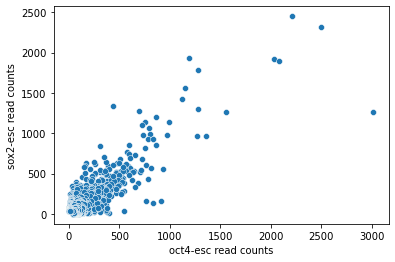

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt
# Getting the last two columns...
sns.scatterplot(data=scatter_df, x=scatter_df.columns[-2], y=scatter_df.columns[-1])
plt.xlabel('oct4-esc read counts')
plt.ylabel('sox2-esc read counts')

Now that we have an appreciation for how similar the experiments are, lets try using the getDifferentialPeaks command to selective find peaks that are ‘specific’ to one experiment relative to another. In the following example we’ll specify “-F 2” to indicate that we want to find Sox2 peaks that are 2-fold higher in the Sox2 experiment relative to the Oct4 experiment:

```
getDifferentialPeaks <peak file to check> <target tag directory> <background tag directory> 
-F <fold change> > output.txt
```

and in our case:

In [ ]:
%%bash
getDifferentialPeaks chipseq_workshop/tagdirs/tfs/sox2-esc/peaks.txt chipseq_workshop/tagdirs/tfs/sox2-esc chipseq_workshop/tagdirs/tfs/oct4-esc -F 2 > chipseq_workshop/sox2-specific-peaks.txt

Now that we have found Sox2 peaks that are relatively uniquely bound by Sox2 (and not Oct4), look at the peak file using less -S, and look at several of the peaks in the genome browser to convince yourself that we have found interesting peaks.

Finally, lets use motif finding to see if we can identify what is unique about the DNA sequences in the Sox2-specific peaks that might have lead to a differential recruitment of Sox2 versus Oct4 at these sites. Run motif finding on the Sox2 specific peaks:
(reminder: this is the general command for finding peaks:

```
findMotifsGenome.pl <peak/BED file> <genome version> <output directory> [options]
```

In [7]:
%%bash
mkdir -p chipseq_workshop/motifs-sox2-specific

In [ ]:
%%bash
# will take ~3 mins
findMotifsGenome.pl chipseq_workshop/sox2-specific-peaks.txt chipseq_workshop/mm9 chipseq_workshop/motifs-sox2-specific -size 100 -p 10 -mask > chipseq_workshop/motifs-sox2-specific/findMotifsGenome.out

---
**12. Notice anything different about these results relative to the results from all Sox2 peaks that we found in step 9?**